In [1]:
import torch
import gpytorch
import numpy as np
import pandas as pd
import scipy.optimize as optimize


from bo_functions import ExactGPModel
from bo_functions import test_train_split
from bo_functions import bo_iter
from bo_functions import bo_iter_w_restarts

In [2]:
#Set Parameters
Theta_True = np.array([1,-1])
BO_iters = 15
restarts = 10
train_iter = 300

emulator = False
sparse_grid = False
verbose = False

shuffle_seed = 6
t=4
noise_std = 0.1
# verbose= False

train_iter = 300
explore_bias = torch.tensor([0,0.1,0.5])

#Pull Experimental data from CSV
exp_data_doc = "exp_data.csv"
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]
n = len(Xexp)

#Define GP Testing space
p=20
Theta1 =  np.linspace(0.5,1.5,p) #1x10
Theta2 =  np.linspace(-1.5,-0.5,p) #1x10
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays
theta1_mesh = theta_mesh[0]
theta2_mesh = theta_mesh[1]

# shape = theta_mesh.shape
# for i in range(len(shape)):
#     print(theta_mesh.shape[i])

Explore Bias: tensor(0.)
Restart Number:  1


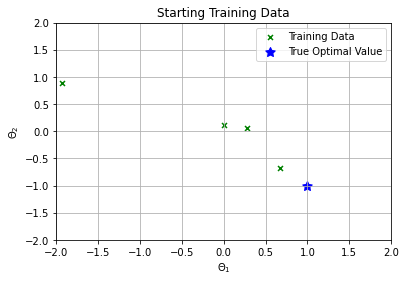

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


In [ ]:
save_fig=False
obj = "LN_obj"

all_data_doc = "all_2_ln_obj_data.csv"
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=","))   

for i in range(len(explore_bias)):
    print("Explore Bias:", explore_bias[i])
    results = bo_iter_w_restarts(BO_iters,all_data_doc,t,theta_mesh,Theta_True,train_iter,explore_bias[i], Xexp, Yexp,
                                 noise_std, obj, restarts, sparse_grid, emulator, verbose,save_fig, shuffle_seed)
    print("The GP predicts that the lowest SSE of", "{:.3e}".format(results[2]), "occurs at \u03B8 =", results[1], "during restart", results[0])

In [ ]:
save_fig=False
obj = "obj"

all_data_doc = "all_2_data.csv"
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=","))   

for i in range(len(explore_bias)):
    print("Explore Bias:", explore_bias[i])
    results = bo_iter_w_restarts(BO_iters,all_data_doc,t,theta_mesh,Theta_True,train_iter,explore_bias[i], Xexp, Yexp,
                                 noise_std, obj, restarts, sparse_grid, emulator, verbose,save_fig, shuffle_seed)
    print("The GP predicts that the lowest SSE of", "{:.3e}".format(results[2]), "occurs at \u03B8 =", results[1], "during restart", results[0])

In [ ]:
##Objective function = ln(SSE)
##USING SCIPY METHOD
##Uses 4 LHS points
q = 2
save_fig=False
obj = "LN_obj"
restarts = 0

#Pull training data from CSV
#Separate training and testing data, uses default of an 80%/20% split
all_data_doc = "all_2_ln_obj_data.csv"
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=","))
train_data, test_data = test_train_split(all_data, shuffle_seed=shuffle_seed)
train_T = train_data[:,1:(q+1)]
train_ln_sse = train_data[:,-1]
t = 4 #Just use last 4 points
train_T = train_T[0:t]
train_ln_sse = train_ln_sse[0:t]

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_T, train_ln_sse, likelihood)


for i in range(len(explore_bias)):
    print("Explore Bias:", explore_bias[i])
    BO_Results = bo_iter(BO_iters,train_T,train_ln_sse,theta_mesh,Theta_True,train_iter,explore_bias[i], Xexp, Yexp, 
                         noise_std, obj, restarts, sparse_grid, emulator, verbose = verbose,save_fig=save_fig)
    if verbose == True:
        print("Exploration Parameter:",explore_bias[i] )
        print("Best_GP_Theta \n",BO_Results[0])
        print("\n Optimal_GP_Theta \n",BO_Results[1])
        print("\n Total SSE \n", BO_Results[2], "\n")

In [ ]:
##Objective function = SSE
##USING SCIPY METHOD
##Uses 4 LHS Training points
shuffle_seed = 6
obj = "obj"
save_fig=False
restarts = 0

#Set 4 Point Training data, Model, and Likelihood
#Pull training data from CSV
#Separate training and testing data, uses default of an 80%/20% split
all_data_doc = "all_2_data.csv"
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=","))
train_data, test_data = test_train_split(all_data, shuffle_seed=shuffle_seed)
train_T = train_data[:,1:(q+1)]
train_sse = train_data[:,-1]
t = 4 #Just use last 4 points
train_T = train_T[0:t]
train_sse = train_sse[0:t]

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_T, train_sse, likelihood)

for i in range(len(explore_bias)):
    print("Explore Bias:", explore_bias[i])
    BO_Results = bo_iter(BO_iters,train_T,train_sse,theta_mesh,Theta_True,train_iter,explore_bias[i], Xexp, Yexp, 
                         noise_std, obj, restarts, sparse_grid, emulator, verbose = verbose,save_fig=save_fig)
    if verbose == True:
        print("Exploration Parameter:",explore_bias[i] )
        print("Best_GP_Theta \n",BO_Results[0])
        print("\n Optimal_GP_Theta \n",BO_Results[1])
        print("\n Total SSE \n", BO_Results[2], "\n")

In [ ]:
##Objective function = ln(SSE)
##USING SCIPY METHOD
##Uses 20 LHS points

save_fig=False
obj = "LN_obj"
restarts = 0

#Pull training data from CSV
#Separate training and testing data, uses default of an 80%/20% split
all_data_doc = "all_2_ln_obj_data.csv"
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=","))
train_data, test_data = test_train_split(all_data, shuffle_seed=shuffle_seed)
train_T = train_data[:,1:(q+1)]
train_ln_sse = train_data[:,-1]

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_T, train_ln_sse, likelihood)

for i in range(len(explore_bias)):
    print("Explore Bias:", explore_bias[i])
    BO_Results = bo_iter(BO_iters,train_T,train_ln_sse,theta_mesh,Theta_True,train_iter,explore_bias[i], Xexp, Yexp, 
                         noise_std, obj, restarts, sparse_grid, emulator, verbose = verbose,save_fig=save_fig)
    if verbose == True:
        print("Exploration Parameter:",explore_bias[i] )
        print("Best_GP_Theta \n",BO_Results[0])
        print("\n Optimal_GP_Theta \n",BO_Results[1])
        print("\n Total SSE \n", BO_Results[2], "\n")

In [ ]:
##Objective function = SSE
##USING SCIPY METHOD
##Uses 20 LHS Training points
save_fig=False
obj = "obj"
restarts = 0

#Set 20 Point Training data, Model, and Likelihood
#Pull training data from CSV
#Separate training and testing data, uses default of an 80%/20% split
all_data_doc = "all_2_data.csv"
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=","))
train_data, test_data = test_train_split(all_data, shuffle_seed=shuffle_seed)
train_T = train_data[:,1:(q+1)]
train_sse = train_data[:,-1]

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_T, train_sse, likelihood)

for i in range(len(explore_bias)):
    print("Explore Bias:", explore_bias[i])
    BO_Results = bo_iter(BO_iters,train_T,train_sse,theta_mesh,Theta_True,train_iter,explore_bias[i], Xexp, Yexp, 
                         noise_std, obj, restarts, sparse_grid, emulator, verbose = verbose,save_fig=save_fig)
    if verbose == True:
        print("Exploration Parameter:",explore_bias[i] )
        print("Best_GP_Theta \n",BO_Results[0])
        print("\n Optimal_GP_Theta \n",BO_Results[1])
        print("\n Total SSE \n", BO_Results[2], "\n")